# Basic Disturbing Function Integration
This notebook illustrates some of the basic elements of initializing and running integrations with celmech's 'PoincareHamiltonian'. The package is designed to construct a Hamiltonian and integrate equations of motion using a collection of user-specified disturbing function terms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# sympy for pretty printing, symbolic manipulation
from sympy import init_printing
init_printing()

## Set up a REBOUND integration

Set up a REBOUND simulation of three planets

In [2]:
import rebound

def get_sim(j,k):
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    mass=1e-5
    
    sim.add(m=mass,e=0.01,P=1)
    sim.add(m=mass,P=j / float(j-k),e=0.1,pomega=np.pi)
    sim.add(m=1e-3,P=10.1,e=0.02,pomega=0.5*np.pi)
    
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim 

Get a simulation with inner pair near a 3:2 mean-motion resonance

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


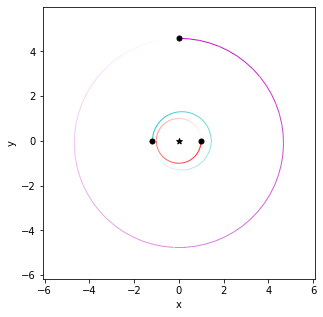

In [3]:
resonance, res_order =3,1
sim=get_sim(3,1)
rebound.plotting.OrbitPlot(sim,color=True);

## Make a celmech model 

Import Poincare variable functions from the celmech package

In [4]:
from celmech import Poincare, PoincareHamiltonian

Initialize model directly from the REBOUND simulation

In [5]:
poincare_variables = Poincare.from_Simulation(sim)

A 'Poincare' object stores a set of particles with Poincare canonical coordinates:
\begin{align}
\Lambda_i = \mu_i\sqrt{G M_* a_i} &;& \lambda_i \\
X_i = \sqrt{2\Gamma_i}\cos(\gamma_i) &;& Y_i=\sqrt{2\Gamma_i}\sin(\gamma_i)
\end{align}
where 
\begin{align}
\Gamma_i = \Lambda_i(1-\sqrt{1-e_i^2}) &;& \gamma_i =-\varpi_i.
\end{align}
By default, celmech uses canonical heliocentric coordinates in a center of mass frame (e.g., Laskar \& Robutel 1995), in which case the appropriate masses are
\begin{align}
\mu_i = \frac{m_0 m_i}{m_0 + m_i} &;& M_i = m_0 + m_i \\
\end{align}

In [6]:
for i,p in enumerate(poincare_variables.particles[1:]):
    print("Lambda_%d = %.3g , Gamma_%d = %.3g"%(i,p.Lambda,i, p.Gamma))

Lambda_0 = 6.28e-05 , Gamma_0 = 3.16e-09
Lambda_1 = 7.19e-05 , Gamma_1 = 3.61e-07
Lambda_2 = 0.0136 , Gamma_2 = 2.72e-06


Now construct a Hamiltonian model with the Poincare varaibles:

In [7]:
Hp = PoincareHamiltonian(poincare_variables)

The 'Hamlitonian' object keeps track of a symbolic Hamiltonian.
By default $N$ distinct Keplerian terms are included.

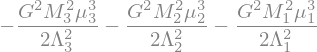

In [8]:
Hp.H

The numerical value of all parameters is tracked as well:

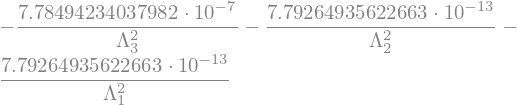

In [9]:
Hp.NH

## Add the disturbing function terms associated with the 3:2 resonance

The "add_all_MMR_and_secular_terms" adds the disturbing function terms
\begin{equation}
\text{3:2 terms}=C_{3,1,0} e'\cos[3\lambda'-2\lambda-\varpi'] + C_{3,1,1} e\cos[3\lambda'-2\lambda-\varpi]
\end{equation}
to the Hamiltonian in canonical coordinates.

Celmech can add terms for any $k$th order resonance as
\begin{equation}
\text{j:(j-k) terms}=\sum_{l=0}^{k} C_{j,k,l}e^{l}e'^{k-l}\cos[j\lambda'-(j-k)\lambda-l\varpi-(k-l)\varpi'] 
\end{equation}

By default, all the adders add terms associated with the first and second planets, but one can specify different ones by specifying their indices through the `indexIn` and `indexOut` keywords:

In [10]:
inner_planet=1
outer_planet=2
print("Adding %d:%d resonance terms for planets %d and %d"%(resonance,resonance-res_order,inner_planet,outer_planet))

# Call to celmech to add terms
Hp.add_eccentricity_MMR_terms(resonance,res_order,max_order=1, indexIn=inner_planet, indexOut=outer_planet)

Adding 3:2 resonance terms for planets 1 and 2


The symbolic Hamiltonian now reflects the new terms:

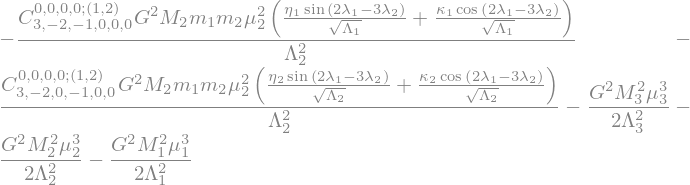

In [11]:
Hp.H

# Integrate the system and compare with the  REBOUND $N$-body results:
'PoincareHamiltonian.state' keeps track of the 'Poincare' variables that can easily be converted back to a REBOUND simulation for direct comparison of orbital elements

In [12]:
Norbits = 6e3
Nout = 500

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))

for i,t in enumerate(times):
    # Store N-body data
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e

    #  Convert the Poincare variables back to rebound simulation to store a's and e's
    simP=Hp.state.to_Simulation()
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e

    # integrate the N-body simulation
    sim.integrate(times[i])
    # integration Poincare simulation
    Hp.integrate(times[i])

Text(0.5, 0, 'Time [planet 1 orbits]')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


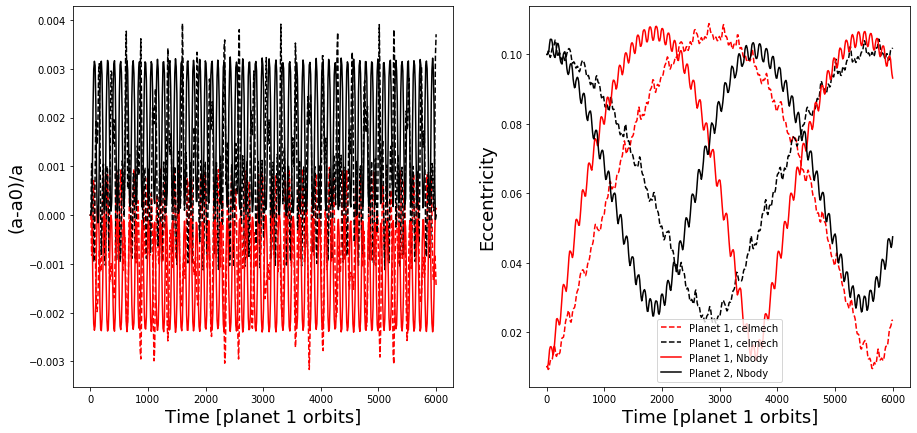

In [13]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].plot(times,(Psma[0]-Psma[0,0])/Psma[0,0],'r--')
ax[0].plot(times,(Psma[1]-Psma[1,0])/Psma[1,0],'k--')

ax[0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[1].plot(times,Pecc[0],'r--',label='Planet 1, celmech')
ax[1].plot(times,Pecc[1],'k--',label='Planet 1, celmech')

ax[1].plot(times,Necc[0],'r',label='Planet 1, Nbody')
ax[1].plot(times,Necc[1],'k',label='Planet 2, Nbody')
ax[1].legend()

ax[0].set_ylabel('(a-a0)/a',fontsize=18)
ax[1].set_ylabel('Eccentricity',fontsize=18)

ax[0].set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax[1].set_xlabel('Time [planet 1 orbits]',fontsize=18)

# Investigate adding more terms
Let's include higher harmonics of the 3:2 MMR along and secular terms and secular interactions between all the planets

In [14]:
resonance, res_order =3,1
secular_order = 2
sim=get_sim(3,1)
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_eccentricity_MMR_terms(resonance,res_order,max_order=3, indexIn=inner_planet, indexOut=outer_planet)
Hp.add_all_secular_terms(max_order=2, indexIn=inner_planet, indexOut=outer_planet)

RuntimeError: THIS METHOD NEEDS TO BE FIXED!!!

In [24]:
Norbits = 6e3
Nout = 500

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))

for i,t in enumerate(times):
    # Store N-body data
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e

    #  Convert the Poincare variables back to rebound simulation to store a's and e's
    simP=Hp.state.to_Simulation()
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e

    # integrate the N-body simulation
    sim.integrate(times[i])
    # integration Poincare simulation
    Hp.integrate(times[i])



Text(0.5,0,'Time [planet 1 orbits]')

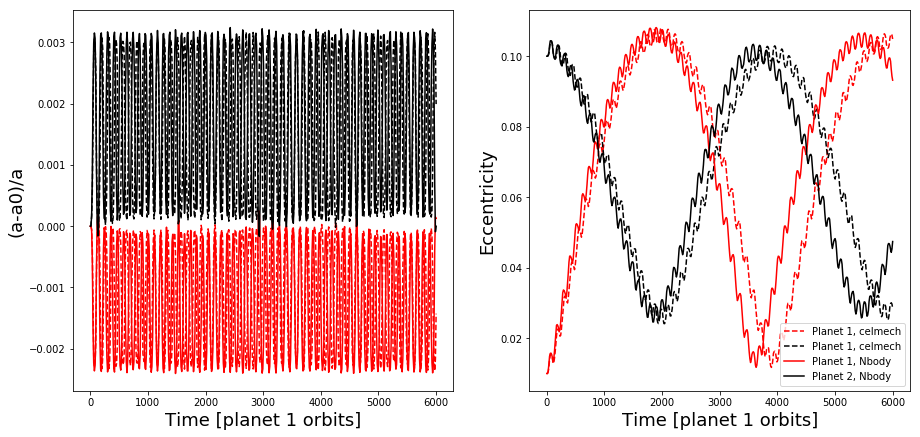

In [25]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].plot(times,(Psma[0]-Psma[0,0])/Psma[0,0],'r--')
ax[0].plot(times,(Psma[1]-Psma[1,0])/Psma[1,0],'k--')

ax[0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[1].plot(times,Pecc[0],'r--',label='Planet 1, celmech')
ax[1].plot(times,Pecc[1],'k--',label='Planet 1, celmech')

ax[1].plot(times,Necc[0],'r',label='Planet 1, Nbody')
ax[1].plot(times,Necc[1],'k',label='Planet 2, Nbody')
ax[1].legend()

ax[0].set_ylabel('(a-a0)/a',fontsize=18)
ax[1].set_ylabel('Eccentricity',fontsize=18)

ax[0].set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax[1].set_xlabel('Time [planet 1 orbits]',fontsize=18)